In [1]:
%pylab inline

import tensorflow as tf
sess = tf.InteractiveSession()
def myshow(image, label=None, **kwargs):
  image = image/1.0
  image = image - amin(image)
  image /= amax(image)
  axis('off')
  if label:
    title(label)
  imshow(image, **kwargs)

Populating the interactive namespace from numpy and matplotlib


### Image Classification Using TensorFlow

* Task : Classify 32x32 RGB images across 10 categories
  - `airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck`

* Data available at [http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz](http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz)

In [2]:
!ls -l data/cifar-10-batches-bin/*_1.bin

-rw-r--r--@ 1 jmchen  eng  30730000 Jun  4  2009 data/cifar-10-batches-bin/data_batch_1.bin


* Each file is 10000 images, each 32 * 32 RGB, plus one byte for label
  - $(32 \times 32 \times 3 \times 1) \times 10000 = 30730000 \ bytes$

* Read the data

In [3]:
# Read data from all the files into one long array of bytes
data = ''
for i in range(1, 6):
  with open(
    'data/cifar-10-batches-bin/data_batch_%d.bin' % i, 'rb') as batch:
    data += batch.read()
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
               'frog', 'horse', 'ship', 'truck']
img_size = 32 * 32 * 3
# One 'record' is an image and a label
record_size = img_size + 1

* Decode the raw bytes and create a mini-batch of Tensors

In [4]:
def get_mini_batch(bytes, batch_size):
  images = []
  labels = []
  for i in range(batch_size):
    offset = i * record_size
    # Slice off a record and decode it in to a Tensor of type uint8
    decoded = bytes[offset:offset + record_size]
    # Slice off the label
    label =  tf.cast(decoded[0:1], tf.int64)
    # Slice off the image and reshape to 3-D
    image = tf.reshape(decoded[1:1+img_size], [3, 32, 32])
    # Reformat from [color, x, y] to [x, y, color]
    image = tf.transpose(image, [1, 2, 0])
    images.append(image)
    labels.append(label)
  return images, labels

In [5]:
def data_as_tensor(batch_size, offset=0):
  return tf.decode_raw(data[offset*record_size:offset*record_size+batch_size*record_size], tf.uint8)
def data_as_nparray(batch_size, offset=0):
  return np.fromstring(
    data[offset*record_size:offset*record_size+batch_size*record_size],
    dtype=np.uint8)
def random_batch(batch_size):
  return data_as_tensor(batch_size, random.randint(50000 - batch_size))
def random_batch_as_np(batch_size):
  return data_as_nparray(batch_size, random.randint(50000 - batch_size))

* Let's look at the images

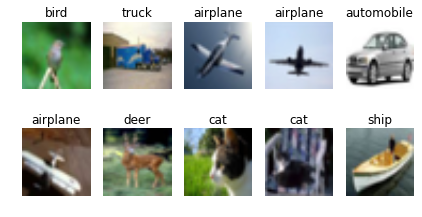

In [6]:
images, labels =  get_mini_batch(random_batch(10), 10)
fig = figure(figsize = (7, 3.5))
for i in range(10):
  image, label = images[i], labels[i]
  subplot(2, 5, i+1)
  myshow(image.eval(), label_names[label.eval()[0]])

* Let's augment the data set
  - Extract a random 24 x 24 crop
  - Random flip left-to-right
  - Random brightness/contrast
  - Whiten the image (subtract mean, divide by variance)

In [7]:
def distort(image):
  image = tf.random_crop(image, [24, 24, 3])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63./255.)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  # This converts the image to floating point values
  image = tf.image.per_image_whitening(image)
  return image

* Let's look at the images again

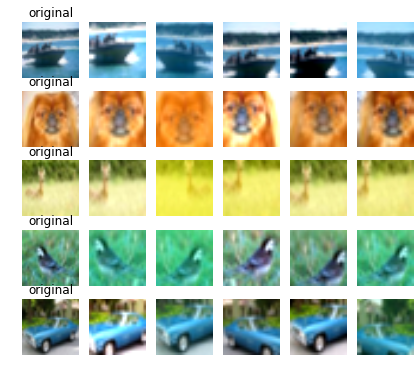

In [8]:
images, _ =  get_mini_batch(random_batch(5), 5)
figsize(7, 6)
for i in range(5):
  subplot(5, 6, i*6+1)
  myshow(images[i].eval(), 'original')
  for j in range(5):
    subplot(5, 6, i*6+j+2)
    myshow(distort(images[i]).eval())

* Let's build a deep convolutional neural network to classify these images

![CIFAR Model](data/cifar_model.png)

* **conv** - Convolution with Relu activation
* **pool** - Max pooling
* **norm** - Local response normalization
* **local** - Fully connected layer

* Declare the model parameters (variables in TensorFlow parlance)

In [9]:
vars = {}

* **conv1**
  - `5x5` convolution
  - `3` input channels (RGB)
  - `64` output channels
  - Shape of the variable tensor is `[5, 5, 3, 64]`

In [10]:
vars['conv1_weights'] = tf.get_variable('conv1_weights',
                                        shape=[5, 5, 3, 64],
                                        initializer=tf.truncated_normal_initializer(stddev=1e-4))
vars['conv1_biases'] = tf.get_variable('conv1_biases',
                                       shape=[64],
                                       initializer=tf.constant_initializer(0.0))

In [11]:
def conv1(input):
  output = tf.nn.conv2d(
    input,
    vars['conv1_weights'],
    [1, 1, 1, 1], # strides
    padding='SAME')
  output = output + vars['conv1_biases']
  return tf.nn.relu(output)

In [12]:
def pool1(input):
  return tf.nn.max_pool(input, ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1],
                        padding='SAME')

In [13]:
def norm1(input):
  return tf.nn.lrn(input, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)

In [14]:
vars['conv2_weights'] = tf.get_variable('conv2_weights',
                                        shape=[5, 5, 64, 64],
                                        initializer=tf.truncated_normal_initializer(stddev=1e-4))
vars['conv2_biases'] = tf.get_variable('conv2_biases',
                                       shape=[64],
                                       initializer=tf.constant_initializer(0.1))
def conv2(input):
  output = tf.nn.conv2d(
    input,
    vars['conv2_weights'],
    [1, 1, 1, 1], # strides
    padding='SAME')
  output = output + vars['conv2_biases']
  return tf.nn.relu(output)

def norm2(input):
  return tf.nn.lrn(input, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)

def pool2(input):
  return tf.nn.max_pool(input, ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

* Everything in working order?

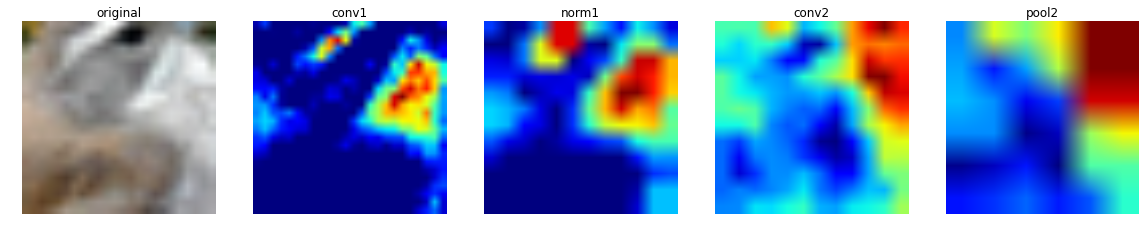

In [15]:
im, _ = get_mini_batch(random_batch(1), 1)
im = distort(im[0])
figsize(20, 5)
subplot(1, 5, 1)
myshow(im.eval(), 'original')
im = tf.expand_dims(im, 0)
tf.initialize_all_variables().run()

x = conv1(im).eval(); subplot(1, 5, 2); myshow(x[0, :, :, 0], 'conv1')
x = norm1(pool1(x)).eval(); subplot(1, 5, 3); myshow(x[0, :, :, 0], 'norm1')
x = conv2(x).eval(); subplot(1, 5, 4); myshow(x[0, :, :, 0], 'conv2')
x = pool2(norm2(x)).eval(); subplot(1, 5, 5); myshow(x[0, :, :, 0], 'pool2')

* **local3**
  - Fully connected layer
  - **pool2** output's shape is `[6, 6, 64]`
  - We'll make **local3** produce `384` features
  - `[6 * 6 * 64, 384]` weight matrix and `[384]` bias vector

In [16]:
vars['local3_weights'] = tf.get_variable('local3_weights',
                                        shape=[6*6*64, 384],
                                        initializer=tf.truncated_normal_initializer(stddev=0.04))
vars['local3_biases'] = tf.get_variable('local3_biases',
                                       shape=[384],
                                       initializer=tf.constant_initializer(0.1))
def local3(input):
  output = tf.matmul(input, vars['local3_weights'])
  output = output + vars['local3_biases']
  return tf.nn.relu(output)

* ** local4**
  - `[384, 192]` weight matrix, `[192]` bias vector

In [17]:
vars['local4_weights'] = tf.get_variable('local4_weights',
                                        shape=[384, 192],
                                        initializer=tf.truncated_normal_initializer(stddev=0.04))
vars['local4_biases'] = tf.get_variable('local4_biases',
                                       shape=[192],
                                       initializer=tf.constant_initializer(0.1))
def local4(input):
  output = tf.matmul(input, vars['local4_weights'])
  output = output + vars['local4_biases']
  return tf.nn.relu(output)

* **softmax_linear**
  - Compute logits to feed into the softmax function
  - `[192, 10]` weight matrix, because we have `10` classes
  - `[10]` bias vector

In [18]:
vars['sm_weights'] = tf.get_variable('sm_weights',
                                    shape=[192, 10],
                                    initializer=tf.truncated_normal_initializer(stddev=1/192.0))
vars['sm_biases'] = tf.get_variable('sm_biases',
                                   shape=[10],
                                   initializer=tf.constant_initializer(0.0))
def softmax_linear(input):
  output = tf.matmul(input, vars['sm_weights'])
  output = output + vars['sm_biases']
  return output

* Everything in working order?
  - Ask the model to predict the class of an image
  - (Hopefully) It should give us uniform predictions

In [19]:
im, _ = get_mini_batch(random_batch(1), 1)
im = distort(im[0])
im = tf.expand_dims(im, 0)
tf.initialize_all_variables().run()
x = pool2(norm2(conv2(norm1(pool1(conv1(im))))))
x = tf.reshape(x, [1, 6*6*64])
x = tf.nn.softmax(softmax_linear(local4(local3(x))))
set_printoptions(precision=2)
print(x.eval())

[[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]]


* Let's train the model to actually classify images
* Define the cost function
  - Cross entropy between the softmax predictions and the actual labels
  - L2 weight decay on the fully connected weights, to keep them from growing too large

In [20]:
def loss(logits, labels):
  cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits, labels)
  weight_decay_loss = (tf.nn.l2_loss(vars['local3_weights']) +
                       tf.nn.l2_loss(vars['local4_weights'])) * 0.004
  return tf.reduce_mean(cross_entropy) + weight_decay_loss

* Lets' ask the model what the loss is for some image

In [21]:
im, label = get_mini_batch(random_batch(1), 1)
im = distort(im[0])
im = tf.expand_dims(im, 0)
label = label[0]
tf.initialize_all_variables().run()
x = pool2(norm2(conv2(norm1(pool1(conv1(im))))))
x = tf.reshape(x, [1, 6*6*64])
logit = softmax_linear(local4(local3(x)))
print(loss(logit, label).eval())

4.66873


In [22]:
# If you are curious, just the cross entropy component
c = tf.nn.sparse_softmax_cross_entropy_with_logits(logit, label).eval()[0]
print(c, exp(c))
# We have 10 classes, so e^cross_entropy ~ 10

(2.2983639, 9.9578772)


* Let's run gradient descent and optimize the model
* We need to do $v = v - \lambda \times \frac{dLoss}{dv}$ for all the variables in the model
* `tf.gradients` can be use to compute $\frac{dLoss}{dv}$
* Aside: `tf.placeholder`
  - A node in the graph that can be substituted with a tensor during execution
  - Convenient to have placeholders as inputs to graph, so the graph can run many times by feeding different tensors to the placeholders.

In [23]:
data_placeholder = tf.placeholder(tf.uint8, name='data')

# Make a training graph that we can repeatedly run on many minibatches.
def train(learning_rate, batch_size):
  images, labels = get_mini_batch(data_placeholder, batch_size)
  # Form one tensor with shape [bathc_size, h, w, colrs]
  image_batch = tf.concat(0, [tf.expand_dims(distort(i), 0)
                              for i in images])
  label_batch = tf.concat(0, labels)
  # Deeeeep CNN!
  x = pool2(norm2(conv2(norm1(pool1(conv1(image_batch))))))
  x = tf.reshape(x, [batch_size, 6*6*64])
  logit = softmax_linear(local4(local3(x)))
  loss_value = loss(logit, label_batch)
  
  # All the variables are available as tf.all_variables()
  all_vars = tf.all_variables()
  grads = tf.gradients(loss_value, all_vars)
  grad_updates = []
  for i, v in enumerate(all_vars):
    update = tf.assign_sub(v, learning_rate * grads[i])
    grad_updates.append(update)
  # tf.group is a handy function to group a list of operations.
  # Running the resulting op would run all the grouped operations.
  return loss_value, tf.group(*grad_updates)

* Let's run for a couple of steps and print the loss (hopefully it should go down :)

In [24]:
loss_value, train_op = train(0.1, 32)
tf.initialize_all_variables().run()
for step_number in range(1, 101):
  # A random file, and a random offset
  filenumber = np.random.randint(5)
  offset = np.random.randint(10000 - 32)
  l, _ = sess.run(
    [loss_value, train_op],
    feed_dict={
      data_placeholder: random_batch_as_np(32)})
  if step_number % 10 == 0:
    print('step %d : %.3f' % (step_number, l))

step 10 : 4.666
step 20 : 4.635
step 30 : 4.602
step 40 : 4.604
step 50 : 4.584
step 60 : 4.555
step 70 : 4.553
step 80 : 4.515
step 90 : 4.520
step 100 : 4.480


* Save your parameters to a file

In [25]:
saver = tf.train.Saver(tf.all_variables())
saver.save(sess, './cifar10_params', global_step=100)

'./cifar10_params-100'

* Restore parameters from a file

In [26]:
saver.restore(sess, './cifar10_params-100')

* Thankfully, I trained for 2500 steps and saved a checkpoint 

In [28]:
saver.restore(sess, './cifar10_params-2500')

* Let's classify some images

In [29]:
def classify():
  figsize(13, 3.0)
  for i in range(10):
    filenumber = np.random.randint(5)
    offset = np.random.randint(10000 - 32)
    orig_im, l = get_mini_batch(random_batch(1), 1)
    im = distort(orig_im[0])
    im = tf.expand_dims(im, 0)
    x = pool2(norm2(conv2(norm1(pool1(conv1(im))))))
    x = tf.reshape(x, [1, 6*6*64])
    x = tf.nn.softmax(softmax_linear(local4(local3(x))))
    set_printoptions(precision=3)
    prediction = label_names[np.argmax(x.eval()[0])]
    ground_truth = label_names[l[0].eval()[0]]
    subplot(2, 5, i+1)
    myshow(orig_im[0].eval(), 'P:'+prediction +', GT:'+ground_truth)

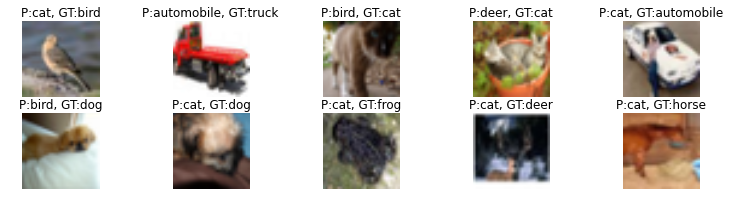

In [30]:
classify()

* Let's look at some filters

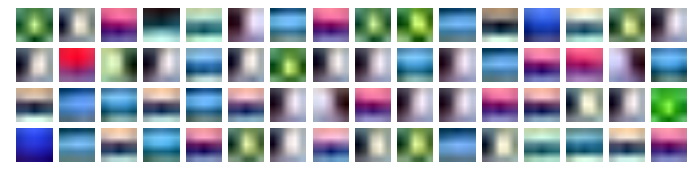

In [31]:
conv1_weights = vars['conv1_weights'].eval()
figsize(12, 2.75)
for i in range(64):
  subplot(4, 16, i+1)
  myshow(conv1_weights[:, :, :, i], aspect='auto')

* Let's apply the filters on an example image and see what the network sees :)

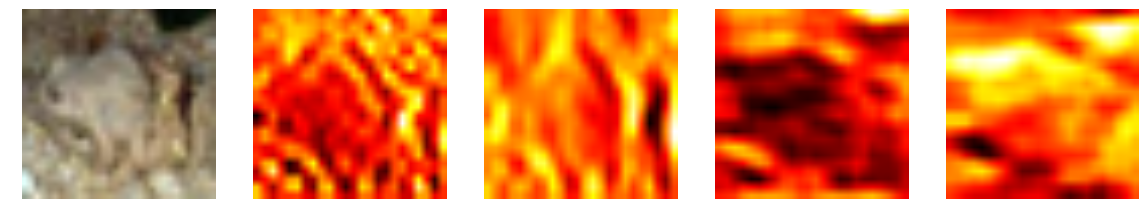

In [32]:
orig_im, l = get_mini_batch(random_batch(1), 1)
im = distort(orig_im[0])
figsize(20, 3.4)
subplot(1, 5, 1)
myshow(orig_im[0].eval(), aspect='auto')
im = tf.expand_dims(im, 0)
output = tf.nn.conv2d(im, vars['conv1_weights'], [1, 1, 1, 1], padding='SAME').eval()
output.shape
hot()
for i in range(4):
  subplot(1, 5, 2+i)
  myshow(output[0, :, :, i], aspect='auto')

### Exercise
* Exponentially decay the learning rate
* Add an extra variable, say, `global_step` to the model
* Make every training step increment `global_step`
* Use $lr = lr * rate^{\frac{global\_step}{decay\_steps}}$

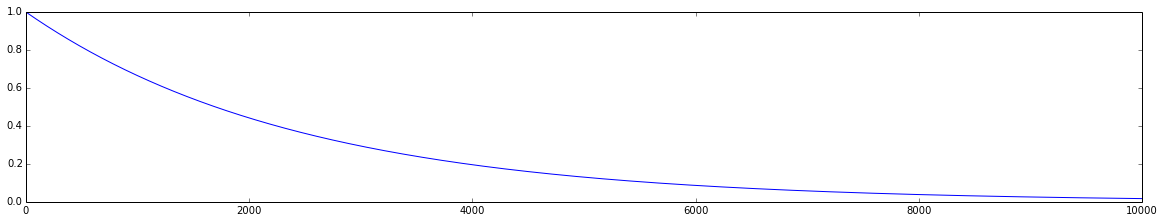

In [33]:
x = np.array(range(10000))
plot(x, np.power(.96, x/100.))